# **MELANOMA DETECTION ASSIGNMENT**

<u>Problem statement</u>:- 
To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
#Remove the dataset if already present.
!rm -r "/content/Skin cancer ISIC The International Skin Imaging Collaboration"

In [4]:
# Extract the dataset in content directory
!unzip "/content/gdrive/MyDrive/UPGRAD/CNN_assignment.zip"

Archive:  /content/gdrive/MyDrive/UPGRAD/CNN_assignment.zip
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010512.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0010889.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024468.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024470.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024511.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024646.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024654.jpg  
  inflating: Skin cancer ISIC The International Skin Imaging Collaboration/Test/actinic keratosis/ISIC_0024707.jpg  
  in

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
path_to_train_directory = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
path_to_test_directory = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"
data_dir_train = pathlib.Path(path_to_train_directory)
data_dir_test = pathlib.Path(path_to_test_directory)

In [6]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [7]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [8]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='training',
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir_train,
    labels='inferred',
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=(img_height, img_width),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset='validation',
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data


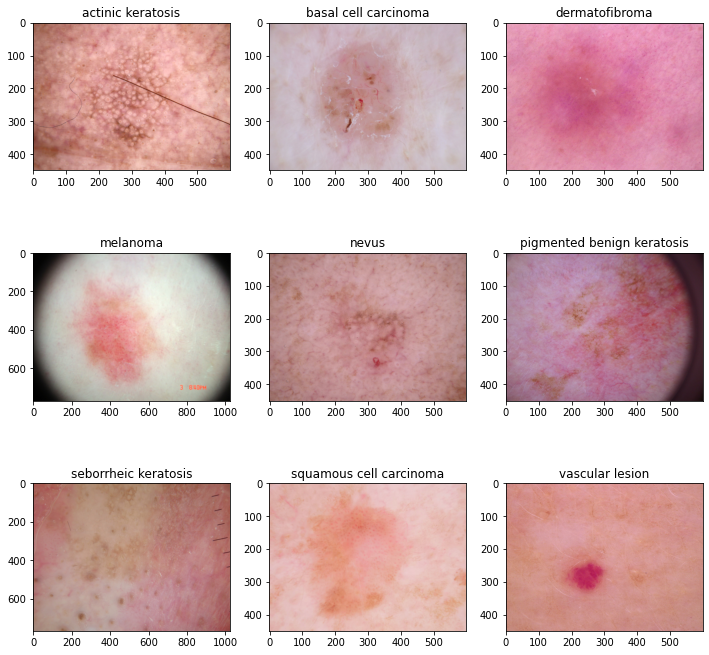

In [11]:
import matplotlib.pyplot as plt

### your code goes here, you can use training or validation data to visualize
plt.figure(figsize=(12,12))

for i in range(9): 
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[0]))
  plt.title(class_names[i])
  plt.imshow(image)  

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# count of classes
num_classes = len(class_names)

In [14]:
### Your code goes here
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='softmax')
])

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [15]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [16]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

### Train the model

In [17]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 16s 71ms/step - loss: 2.0147 - accuracy: 0.2584 - val_loss: 1.7957 - val_accuracy: 0.3714
Epoch 2/20
56/56 [==============================] - 1s 24ms/step - loss: 1.6578 - accuracy: 0.4146 - val_loss: 1.4861 - val_accuracy: 0.4787
Epoch 3/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3956 - accuracy: 0.4994 - val_loss: 1.3867 - val_accuracy: 0.5213
Epoch 4/20
56/56 [==============================] - 1s 24ms/step - loss: 1.3714 - accuracy: 0.5279 - val_loss: 1.3963 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1668 - accuracy: 0.5815 - val_loss: 1.3867 - val_accuracy: 0.5034
Epoch 6/20
56/56 [==============================] - 1s 24ms/step - loss: 1.1198 - accuracy: 0.6021 - val_loss: 1.4270 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 1s 24ms/step - loss: 1.0554 - accuracy: 0.6155 - val_loss: 1.6988 - val_accuracy: 0.5190
Epoch 8/20
5

### Visualizing training results

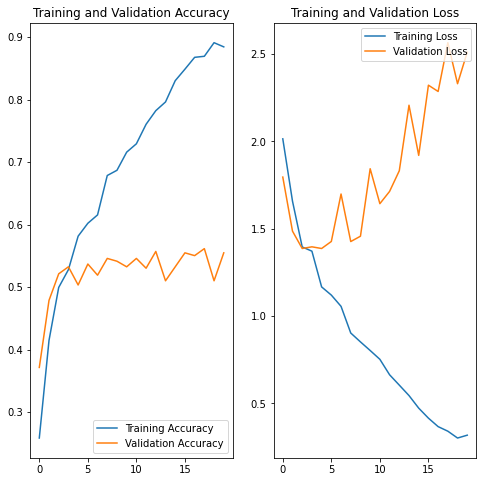

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> ### <u>Findings from the First (Base) Model</u> :-
* The model is overfitting because there is huge gap between train-set accuracy and validation-set accuracy
* We can also see the difference in loss functions of training and validation datasets

### Augmentation for second model

In [19]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
# Your code goes here
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip(
        "horizontal_and_vertical",
                      input_shape=(img_height,
                                  img_width,
                                  3)
                      ),
    layers.RandomRotation(0.3),
    layers.RandomZoom(0.3),
  ]
)

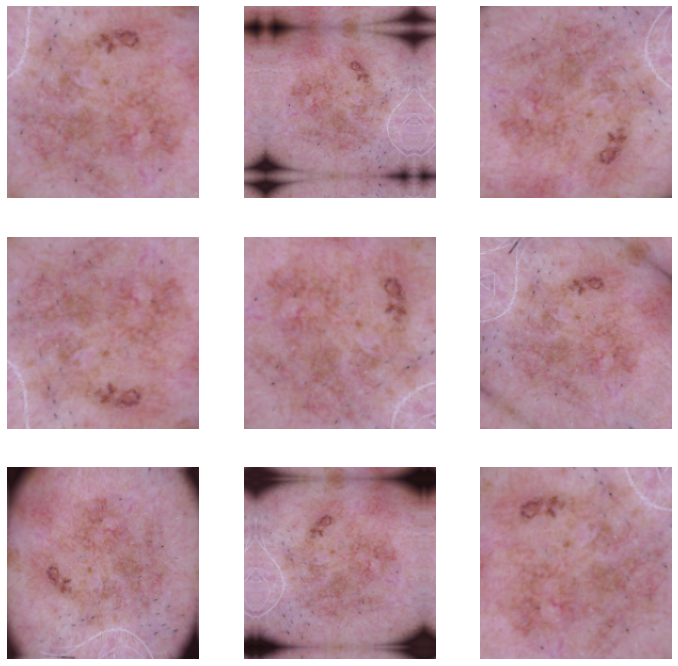

In [20]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
# Your code goes here
plt.figure(figsize=(12, 12))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Model Building


In [21]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

## Your code goes here

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs", activation='softmax')
])

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

### Compiling the model

In [23]:
## Your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [24]:
## Your code goes here, note: train your model for 20 epochs
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
56/56 [==============================] - 3s 33ms/step - loss: 2.3427 - accuracy: 0.1925 - val_loss: 2.0717 - val_accuracy: 0.2752
Epoch 2/20
56/56 [==============================] - 2s 30ms/step - loss: 1.8536 - accuracy: 0.3253 - val_loss: 1.8395 - val_accuracy: 0.3512
Epoch 3/20
56/56 [==============================] - 2s 33ms/step - loss: 1.6395 - accuracy: 0.4068 - val_loss: 1.6625 - val_accuracy: 0.3870
Epoch 4/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5699 - accuracy: 0.4464 - val_loss: 1.5702 - val_accuracy: 0.4609
Epoch 5/20
56/56 [==============================] - 2s 30ms/step - loss: 1.5028 - accuracy: 0.4738 - val_loss: 1.5056 - val_accuracy: 0.4743
Epoch 6/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4215 - accuracy: 0.4900 - val_loss: 1.5352 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 2s 30ms/step - loss: 1.4257 - accuracy: 0.4866 - val_loss: 1.5152 - val_accuracy: 0.4653
Epoch 8/20
56

### Visualizing the results

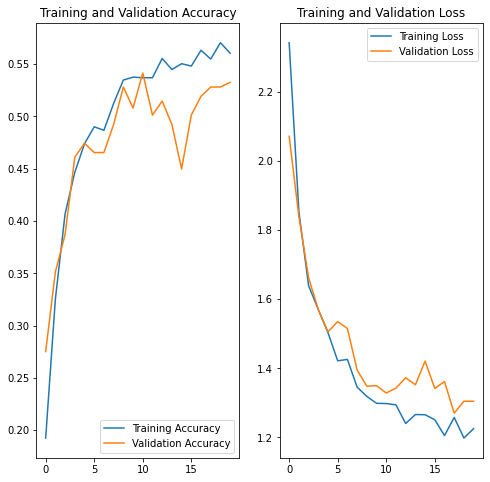

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

> ### <u>Findings from the Second Model</u> :-
* There is no improvement in the accuracy but we can definitely see the overfitting problem has been solved due to data augmentation.
* We can increase the epochs to increase the accuracy, but it's too early for any type of judgement.




#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

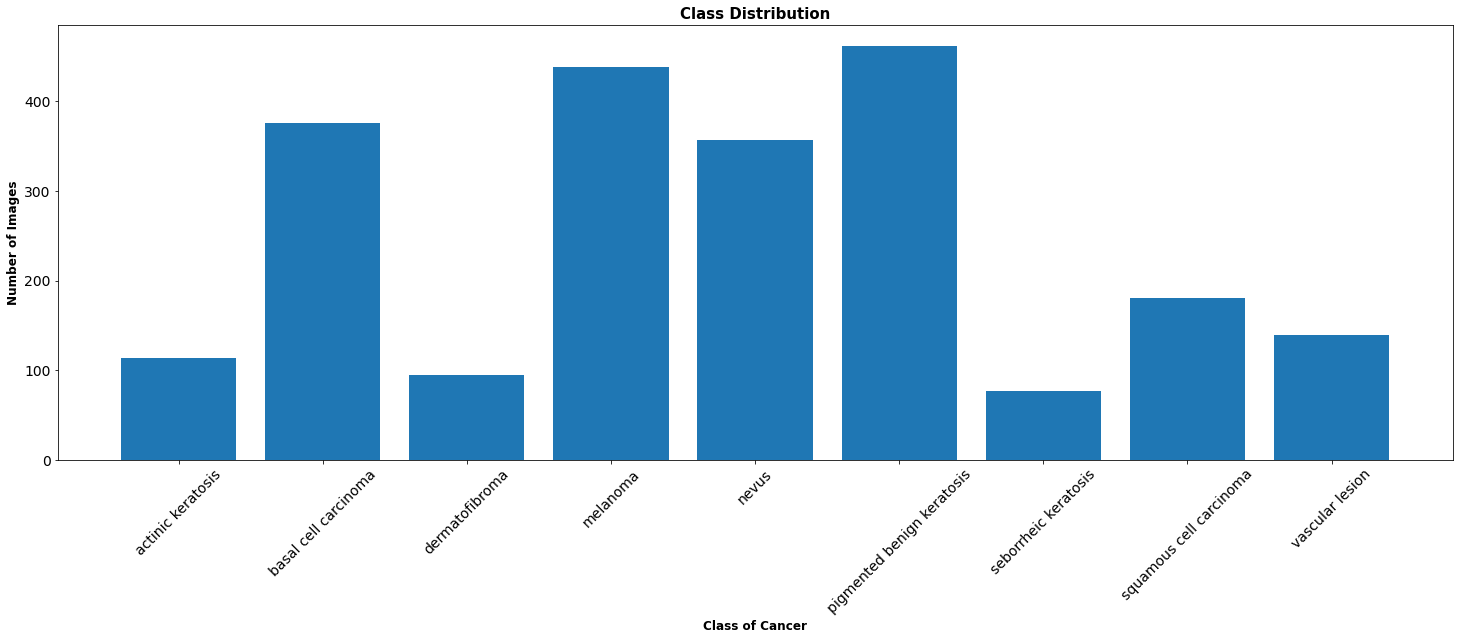

In [26]:
## Your code goes here.
total_count = len(list(data_dir_train.glob('*/*.jpg')))
percentage = []
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
    percentage.append(round(len(list(data_dir_train.glob(i+'/*.jpg'))) / total_count * 100, 1))
plt.figure(figsize=(25,8))
plt.bar(class_names,count)
plt.title("Class Distribution", fontsize=15, fontweight='bold')
plt.xlabel("Class of Cancer", fontsize=12, fontweight='bold')
plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

In [27]:
df = pd.DataFrame({'Class Name' : class_names,
                                'Count' : count,
                                '% of Total' : percentage }, 
                                columns=['Class Name','Count', '% of Total'])
df.sort_values(by = ['% of Total'], ascending=False)

,Class Name,Count,% of Total
5,pigmented benign keratosis,462,20.6
3,melanoma,438,19.6
1,basal cell carcinoma,376,16.8
4,nevus,357,15.9
7,squamous cell carcinoma,181,8.1
8,vascular lesion,139,6.2
0,actinic keratosis,114,5.1
2,dermatofibroma,95,4.2
6,seborrheic keratosis,77,3.4


#### **Todo:** Write your findings here: 
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


> ### <u>Findings of the Class Distribution</u> 
* Answer-1 :- "Seborrheic keratosis" has the least number of samples.
* Answer-2:- "Pigmented benign keratosis"	and "Melanoma" classes dominate the data in terms of proportion.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [28]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [29]:
path_to_training_dataset = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.flip_left_right(probability=0.3)
    # p.flip_top_bottom(probability=0.3)
    # p.rotate(probability=0.3, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.3, min_factor=1.1, max_factor=1.6)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A36DBFF50>: 100%|██████████| 500/500 [00:09<00:00, 51.32 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7A36A8AAD0>: 100%|██████████| 500/500 [00:10<00:00, 47.46 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A36AF1390>: 100%|██████████| 500/500 [00:12<00:00, 39.66 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F7A36B8C590>: 100%|██████████| 500/500 [00:48<00:00, 10.41 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A356F9E50>: 100%|██████████| 500/500 [00:34<00:00, 14.45 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F7A36A74E50>: 100%|██████████| 500/500 [00:09<00:00, 53.53 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F7A4A67B750>: 100%|██████████| 500/500 [00:18<00:00, 27.18 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7A35752D90>: 100%|██████████| 500/500 [00:09<00:00, 54.18 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F7A36B9AF50>: 100%|██████████| 500/500 [00:09<00:00, 53.67 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [30]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [31]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/Skin cancer ISIC The International Sk...,actinic keratosis
1,/content/Skin cancer ISIC The International Sk...,actinic keratosis
2,/content/Skin cancer ISIC The International Sk...,actinic keratosis
3,/content/Skin cancer ISIC The International Sk...,actinic keratosis
4,/content/Skin cancer ISIC The International Sk...,actinic keratosis
...,...,...
2234,/content/Skin cancer ISIC The International Sk...,vascular lesion
2235,/content/Skin cancer ISIC The International Sk...,vascular lesion
2236,/content/Skin cancer ISIC The International Sk...,vascular lesion
2237,/content/Skin cancer ISIC The International Sk...,vascular lesion


In [32]:
from glob import glob
path_list_new = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# path_list_new

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
# lesion_list_new

In [34]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

df2 = new_df['Label'].value_counts().rename_axis('Class of Cancer').reset_index(name='Number of Images')
df2

,Class of Cancer,Number of Images
0,pigmented benign keratosis,962
1,melanoma,938
2,basal cell carcinoma,876
3,nevus,857
4,squamous cell carcinoma,681
5,vascular lesion,639
6,actinic keratosis,614
7,dermatofibroma,595
8,seborrheic keratosis,577


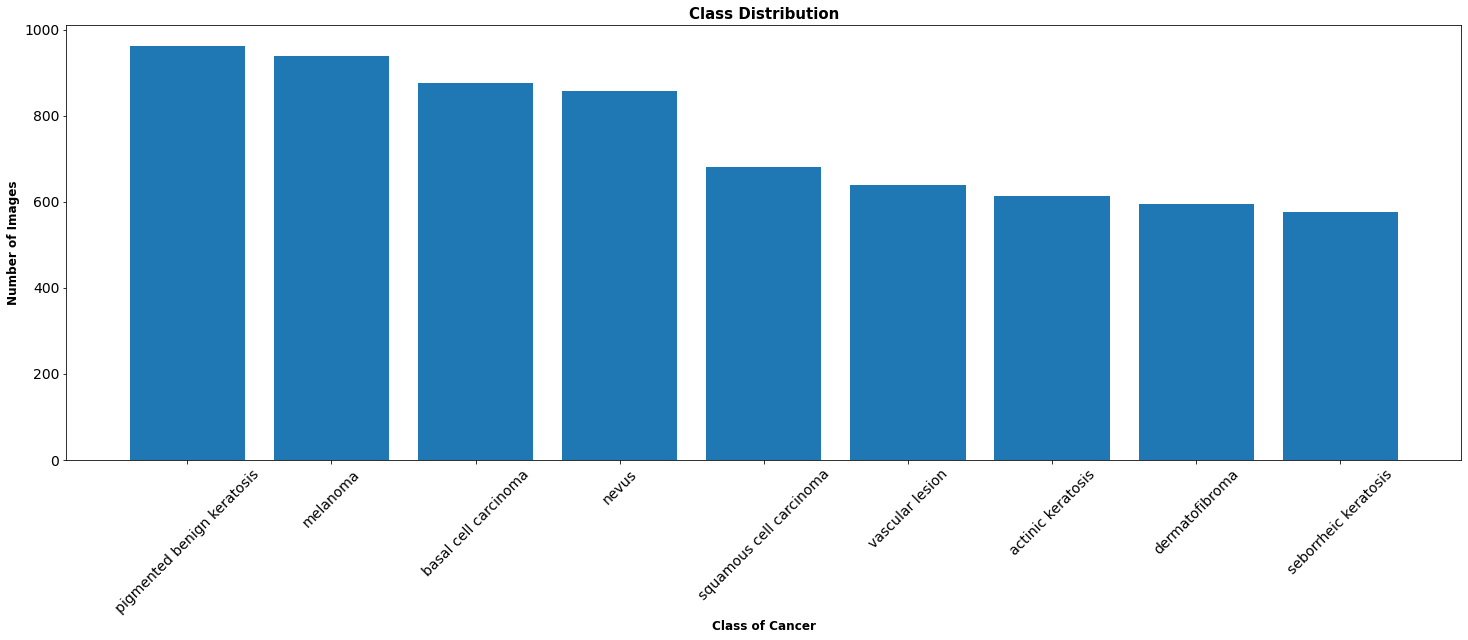

In [35]:
from sklearn.preprocessing import LabelEncoder 
from collections import Counter
plt.figure(figsize=(25,8))
plt.bar(df2['Class of Cancer'],df2['Number of Images'])
plt.title("Class Distribution", fontsize=15, fontweight='bold')
plt.xlabel("Class of Cancer", fontsize=12, fontweight='bold')
plt.ylabel("Number of Images", fontsize=12, fontweight='bold')
plt.xticks(fontsize=14, rotation=45)
plt.yticks(fontsize=14)
plt.show()

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

Train the model on the data created using Augmentor

In [36]:
batch_size = 32
img_height = 180
img_width = 180

###Create a training dataset

In [37]:
# data_dir_train="path to directory with training data + data created using augmentor"

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training", ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation", ## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [39]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model Creation

In [40]:
model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  # layers.Dropout(0.2),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  layers.Dense(num_classes, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 90, 90, 16)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 45, 45, 32)       

### Compile model 

In [42]:
## your code goes here
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])


### Train model

In [43]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/50
169/169 [==============================] - 36s 55ms/step - loss: 2.3670 - accuracy: 0.2081 - val_loss: 3.3537 - val_accuracy: 0.1381
Epoch 2/50
169/169 [==============================] - 5s 27ms/step - loss: 1.7725 - accuracy: 0.3552 - val_loss: 1.9162 - val_accuracy: 0.3422
Epoch 3/50
169/169 [==============================] - 5s 27ms/step - loss: 1.5514 - accuracy: 0.4228 - val_loss: 1.5356 - val_accuracy: 0.4053
Epoch 4/50
169/169 [==============================] - 5s 27ms/step - loss: 1.4914 - accuracy: 0.4379 - val_loss: 1.8999 - val_accuracy: 0.3140
Epoch 5/50
169/169 [==============================] - 5s 27ms/step - loss: 1.4434 - accuracy: 0.4594 - val_loss: 1.5925 - val_accuracy: 0.3808
Epoch 6/50
169/169 [==============================] - 5s 29ms/step - loss: 1.4009 - accuracy: 0.4679 - val_loss: 1.6959 - val_accuracy: 0.3519
Epoch 7/50
169/169 [==============================] - 5s 27ms/step - loss: 1.3432 - accuracy: 0.4954 - val_loss: 1.5571 - val_accuracy: 0.368

###  Visualize the model results

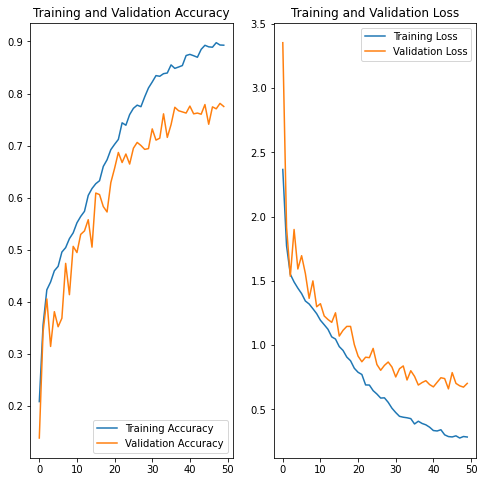

In [44]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

###  Analyzing results (Conclusions)




> ### <u>Findings from the Third (Augmented) Model</u> :-
* The final model uses the dropout layer and batch normalization and is able to prevent some level of overfitting. 
* We can also see the difference in loss functions of training and validation datasets
* Accuracy on training data has increased by using Augmentor library
* The Model can be further improved by tuning the hyperparameters and increasing the epochs.

### Evaluating Model

In [45]:
#Metrics
_,train_acc=model.evaluate(train_ds)
_,val_acc=model.evaluate(val_ds)
print("The train accuracy is ",round(train_acc*100,2))
print("The validation accuracy is ",round(val_acc*100,2))

43/43 [==============================] - 1s 12ms/step - loss: 0.7022 - accuracy: 0.7751
The train accuracy is  92.53
The validation accuracy is  77.51
